# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    for i in range(num_examples):
        print(f"Example {i+1}, label =  {train_labels[i]}:\n\n", train_data[i], "\n")
    

P1(5)

Example 1, label =  1:

 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

Example 2, label =  3:

 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries. 

Example

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    print("Word unigrams")
    cv = CountVectorizer(input="content", ngram_range=(1, 1), analyzer="word")
    cv.fit(train_data)
    train_arr = cv.transform(train_data)
    
    # What is the size of the vocabulary?
    features = sorted(cv.get_feature_names())
    vocab_size = len(features)
    print(f"  Vocabulary size: ".ljust(40), vocab_size)
    
    # What is the average number of non-zero features per example?
    av_non_zero = train_arr.nnz / train_arr.shape[0]
    print(f"  Average non-zero features per example:".ljust(40), round(av_non_zero, 2))
    
    # What is the fraction of the non-zero entries in the matrix? 
    frac_non_zero = train_arr.nnz / (train_arr.shape[0] * train_arr.shape[1])
    print(f"  Fraction non-zero in matrix:".ljust(40), round(frac_non_zero, 6))
    
    # What are the 0th and last feature strings (in alphabetical order)?
    print(f"  0th feature:".ljust(40), features[0])
    print(f"  Last feature:".ljust(40), features[-1])

    print("\nCustom vocabulary")
    cv2 = CountVectorizer(input="content", vocabulary=["atheism", "graphics", "space", "religion"],
                          ngram_range=(1, 1), analyzer="word")
    cv2.fit(train_data)
    train_arr2 = cv2.transform(train_data)
    
    # What is the average number of non-zero features per example?
    av_non_zero2 = train_arr2.nnz / train_arr2.shape[0]
    print(f"  Average non-zero features per example:".ljust(40), round(av_non_zero2, 2))
    
    print("\nCharacter bigram and trigrams")
    cv3 = CountVectorizer(input="content", analyzer="char", ngram_range=(2, 3))
    cv3.fit(train_data)
    train_arr3 = cv3.transform(train_data)
    
    # What is the size of the vocabulary?
    features3 = sorted(cv3.get_feature_names())
    vocab_size3 = len(features3)
    print(f"  Vocabulary size: ".ljust(40), vocab_size3)
    
    print("\nWords in 10+ documents")
    cv4 = CountVectorizer(input="content", ngram_range=(1, 1), analyzer="word", min_df=10)
    cv4.fit(train_data)
    train_arr4 = cv4.transform(train_data)
    print(f"  Vocabulary size: ".ljust(40), len(cv4.vocabulary_))
    
    print("\nDev-Train comparison")
    # What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
    cv_dev = CountVectorizer(input="content", ngram_range=(1, 1), analyzer="word")
    cv_dev.fit(dev_data)
    in_dev_not_in_train = set(cv_dev.vocabulary_) - set(cv.vocabulary_)
    print(f"  Words in dev not in train:".ljust(40), len(in_dev_not_in_train))

    
P2()

Word unigrams
  Vocabulary size:                       26879
  Average non-zero features per example: 96.71
  Fraction non-zero in matrix:           0.003598
  0th feature:                           00
  Last feature:                          zyxel

Custom vocabulary
  Average non-zero features per example: 0.27

Character bigram and trigrams
  Vocabulary size:                       35478

Words in 10+ documents
  Vocabulary size:                       3064

Dev-Train comparison
  Words in dev not in train:             4027


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

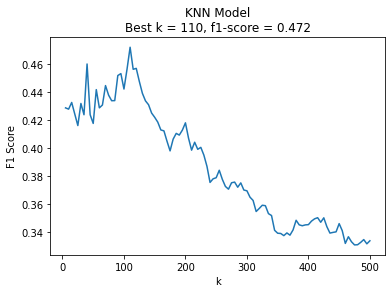

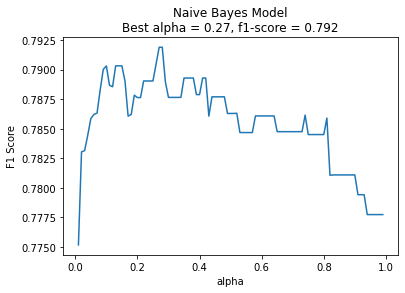

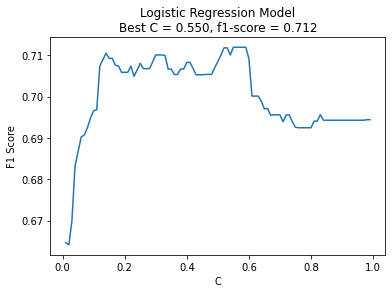

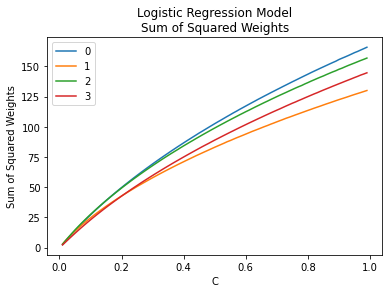

In [5]:
def P3():
    
    def plot_model(params, scores, title: str, 
                   metric_name: str, param_name: str):
        """Helper function to plot model parameters vs. scores"""
        fig, ax = plt.subplots()
        ax.plot(params, scores)
        ax.set_title(title)
        ax.set_ylabel(metric_name)
        ax.set_xlabel(param_name)
        plt.show()
    
    # Transform the training data to word unigram feature vectors:
    cv = CountVectorizer(input="content", ngram_range=(1, 1), analyzer="word")
    cv.fit(train_data)
    train_arr = cv.transform(train_data)
    dev_arr = cv.transform(dev_data)

    # Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score:
    best_k, best_score = None, -np.inf
    ks, scores = list(range(5, 501, 5)), list()

    for k in ks:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_arr, train_labels)
        y_pred = model.predict(dev_arr)
        score = metrics.f1_score(dev_labels, y_pred, average="weighted")
        scores.append(score)
        if score > best_score:
            best_score, best_k = score, k
    title = f"KNN Model\nBest k = {best_k}, f1-score = {best_score:.3f}"
    plot_model(ks, scores, title, "F1 Score", "k")
    
    # Produce several Naive Bayes models by varying smoothing (alpha), including  
    # one with alpha set approximately to optimize f1 score.
    best_alpha, best_score = None, -np.inf
    alphas, scores = np.arange(0.01, 1, 0.01), list()
    for alpha in alphas:
        model = MultinomialNB(alpha=alpha, fit_prior=True, class_prior=None)
        model.fit(train_arr, train_labels)
        y_pred = model.predict(dev_arr)
        score = metrics.f1_score(dev_labels, y_pred, average="weighted")
        scores.append(score)
        if score > best_score:
            best_score, best_alpha  = score, alpha
    title = f"Naive Bayes Model\nBest alpha = {best_alpha}, f1-score = {best_score:.3f}"
    plot_model(alphas, scores, title, "F1 Score", "alpha")
    
    # Produce several Logistic Regression models by varying L2 regularization strength (C), 
    # including one with C set approximately to optimize f1 score. For each model, show 
    # the C value, f1 score, and sum of squared weights for each topic.
    best_c, best_score = None, -np.inf
    cs, scores = np.arange(0.01, 1, 0.01), list()

    # Dict to store sum of squared weights for each topic:
    ssw = {i: list() for i in range(4)}
    for c in cs:
        model = LogisticRegression(penalty="l2", C=c, fit_intercept=True, solver="liblinear")
        model.fit(train_arr, train_labels)
        y_pred = model.predict(dev_arr)
        score = metrics.f1_score(dev_labels, y_pred, average="weighted")
        scores.append(score)
        for i in range(4):
            ssw[i].append(sum(model.coef_[i] ** 2))
        if score > best_score:
            best_score, best_c = score, c
    title = f"Logistic Regression Model\nBest C = {best_c:.3f}, f1-score = {best_score:.3f}"
    plot_model(cs, scores, title, "F1 Score", "C")

    fig, ax = plt.subplots()
    for feature, weight_sum in ssw.items():
        ax.plot(cs, weight_sum, label=feature)
    ax.set_title("Logistic Regression Model\nSum of Squared Weights")
    ax.set_ylabel("Sum of Squared Weights")
    ax.set_xlabel("C")
    ax.legend()
    plt.show()


P3()

In [6]:
cv = CountVectorizer(input="content", ngram_range=(1, 1), analyzer="word")
cv.fit(train_data)
train_arr = cv.transform(train_data)
train_arr.shape

(2034, 26879)

ANSWER:

* Why doesn't k-Nearest Neighbors work well for this problem?

KNN requires distance computation between observations based on the differences between the feature values for those observations. The feature set is a large sparse matrix, and for any 2 observations there is a high chance that they won't share many non-zero features, and therefore for most pairs of observations distance calculations will be very similar. The "Curse of Dimensionality" means that because it is a very high-dimensional feature space the distance calculations between different pairs of samples will be very similar.

* Why doesn't Logistic Regression work as well as Naive Bayes does?

According to <a href="http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf">Ng and Jordan's research</a>, as the training set size increases, in the limit the performance of the discriminative model (i.e. Logisic Regression) will surpass the performance of the generative model (i.e. Naive Bayes). However, the generative model approaches its asymptotic error rate much faster than the discriminative model; potentially with a number of observations that is logarithmic to the number of features, compared to a linear relationship with the discriminative model. Since in our training data the number of features (26879) is much larger than the number of observations (2034), this explains why the Naive Bayes model outperforms the Logistic Model in this particular case. If we were able to get hold of many more training examples we may be able to improve the Logistic Model to match or exceed the performance of the Naive Bayes model.

* What is the relationship between logistic regression's sum of squared weights vs. C value?

C is the inverse of the regularization strength, therefore the smaller C is the more the size of the weights of the model are penalized, so the sum of squared weights is smaller.


### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [7]:
# Pandas to show the table:
import pandas as pd


def P4():
    cv = CountVectorizer(analyzer="word", ngram_range=(2, 2))
    cv.fit(train_data)
    train_arr = cv.transform(train_data)
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(train_arr, train_labels)
    features = cv.get_feature_names()
    best_feature_indices = list()
    for i in model.classes_:
        best_feature_indices += list(np.argsort(model.coef_[i])[-5:][::-1])
    feature_weights = dict()
    for t, topic in enumerate(newsgroups_train.target_names):
        feature_weights[topic] = [model.coef_[t][i] for i in best_feature_indices]
    return pd.DataFrame(feature_weights, index=[features[i] for i in best_feature_indices])

    
P4()

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
claim that,0.605549,-0.199039,-0.274344,-0.140364
cheers kent,0.555720,-0.697908,-0.663766,0.534805
was just,0.482050,-0.131419,-0.128880,-0.227468
you are,0.472741,-0.279913,-0.481300,0.028383
are you,0.446953,-0.248256,-0.097135,-0.305624
looking for,-0.630341,1.108368,-0.500067,-0.571867
in advance,-0.459351,0.832570,-0.438500,-0.418454
comp graphics,-0.292166,0.801202,-0.370885,-0.285186
out there,-0.274802,0.758680,-0.479054,-0.277088
is there,-0.340882,0.754980,-0.468250,-0.257078


ANSWER:

* Do you see any surprising features in this table?

One feature that is slightly surprising is the appearance of "cheers kent" for the atheism and religion categories. This isn't a pair of words that has any obvious relationship to these topics, but instead appears to be an artifact of the training data; i.e. there was likely someone called Kent who was a very active poster in the religion and atheism newsgroups. Another strange feature in the religion category is "the fbi" - it is hard to say why this feature has such importance for this topic, we would probably need to inspect the posts containing that string to figure out why.

It is also somewhat surprising to me that some of the features are very generic terms that don't have an obvious meaning with regards to the topic; e.g. "it was" in space, "is there" in computer graphics, and "was just" in atheism. I would have expected more narrow terms specific to the topic to appear, such as "the moon" in the space newsgroup. It may be the case that as with the "cheers kent" example, that these more generic combinations of words just reflect particular linguistic habits of posters who comment frequently in those newsgroups.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [8]:

import string  # For removing punctuation.

nltk.download("wordnet")
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))


def better_preprocessor(s):
    
    # Make lowercase:
    s = s.lower()

    # Replace all numbers with arbitrary number 123:
    s = re.sub("\d+", "123", s)

    # Replace all punctuation:
    s = re.sub(f"[{string.punctuation}]", " ", s)
    
    # Use the NLTK to tokenize and stem the words:
    words = nltk.word_tokenize(s)
    
    # Remove stopwords:
    words = list(filter(lambda w: w not in stopwords, words))
    
    # Lemmatize:
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for pos in ("a", "v", "n"):
        words = [lemmatizer.lemmatize(w, pos=pos) for w in words]
        
    # Stem:
    stemmer = nltk.stem.PorterStemmer()
    words = [stemmer.stem(w) for w in words]
        
    # Cap words to a maximum length.
    words = [w[:12] for w in words]

    return " ".join(words)


def P5():
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")

    # Base vectorizer with no pre-processing. Since sklearn makes lowercase 
    # with preprocessor=None, use a lambda function to do nothing to string:
    cv = CountVectorizer(input="content", preprocessor=lambda s: s, 
                         ngram_range=(1, 1), analyzer="word")
    cv.fit(train_data)
    train_arr = cv.transform(train_data)
    model.fit(train_arr, train_labels)
    pred = model.predict(cv.transform(dev_data))
    score = metrics.f1_score(dev_labels, pred, average="weighted")
    print(f"Base vectorizer\n  Score = {score:.3f}, vocabulary size = {len(cv.vocabulary_):,}\n")

    # New vectorizer with custom preprocessor:
    cv2 = CountVectorizer(input="content", preprocessor=better_preprocessor, 
                          ngram_range=(1, 1), analyzer="word")
    cv2.fit(train_data)
    train_arr2 = cv2.transform(train_data)
    model.fit(train_arr2, train_labels)
    pred2 = model.predict(cv2.transform(dev_data))
    score2 = metrics.f1_score(dev_labels, pred2, average="weighted")
    print(f"Custom processor vectorizer\n  Score = {score2:.3f}, vocabulary size = {len(cv2.vocabulary_):,}\n")
    
    print(f"Vocabulary change = {len(cv2.vocabulary_) - len(cv.vocabulary_):,}")
    return cv, cv2

    
cv, cv2 = P5()

[nltk_data] Downloading package wordnet to /Users/tp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Base vectorizer
  Score = 0.707, vocabulary size = 33,291

Custom processor vectorizer
  Score = 0.733, vocabulary size = 16,715

Vocabulary change = -16,576


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

C            Vocabulary Size      F1 score
1000.000     25,831               0.70
500.000      25,820               0.72
100.000      25,823               0.71
50.000       25,811               0.72
10.000       24,778               0.70
1.000        9,402                0.71
0.100        915                  0.68
0.010        33                   0.57


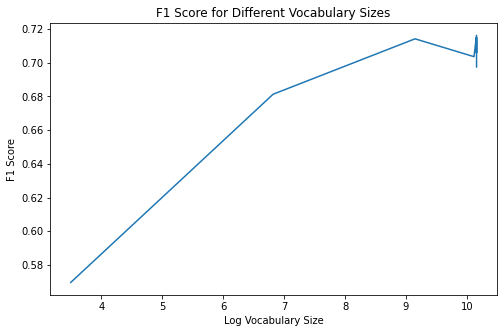

In [9]:
def P6():
    
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    cv = CountVectorizer(input="content", preprocessor=None, ngram_range=(1, 1), analyzer="word")
    cv.fit(train_data)
    features = cv.get_feature_names()
    train_arr = cv.transform(train_data)
    dev_arr = cv.transform(dev_data)
    
    cs, f1_scores, vocab_sizes = [1000, 500, 100, 50, 10, 1, 0.1, 0.01], list(), list()
    print("C".ljust(12), "Vocabulary Size".ljust(20), "F1 score")
    for c in cs:
        # Fit the L1 model:
        l1_model = LogisticRegression(penalty="l1", C=c, solver="saga", max_iter=100, tol=0.015)
        l1_model.fit(train_arr, train_labels)

        # Filter the coefficients to those greater than zero:
        coef = pd.DataFrame(l1_model.coef_.T)
        coef["sum"] = coef.sum(axis=1)
        keep_ix = coef[coef["sum"] > 0].index
        new_vocab = [features[i] for i in keep_ix]

        # Create the new vectorizer with the smaller vocabulary: 
        cv2 = CountVectorizer(input="content", preprocessor=None, ngram_range=(1, 1), analyzer="word", 
                              vocabulary=new_vocab)
        cv2.fit(train_data)
        train_arr2 = cv2.transform(train_data)

        # Fit the L2 model:
        l2_model = LogisticRegression(penalty="l2", C=0.5, solver="newton-cg")
        l2_model.fit(train_arr2, train_labels)

        # Get the F1 score:
        pred = l2_model.predict(cv2.transform(dev_data))
        f1_score = metrics.f1_score(dev_labels, pred, average="weighted")

        # Store the results:
        f1_scores.append(f1_score)
        vocab_sizes.append(len(new_vocab))

        print(f"{c:.3f}".ljust(12), f"{len(new_vocab):,}".ljust(20), f"{f1_score:.2f}")

    # Produce the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(np.log(vocab_sizes), f1_scores)
    ax.set_xlabel("Log Vocabulary Size")
    ax.set_ylabel("F1 Score")
    ax.set_title("F1 Score for Different Vocabulary Sizes")
    plt.show()


P6()

ANSWER:

* How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

The models with the reduced vocabularies generally perform worse than those with the larger vocabularies, however there is some improvement for slight reductions in the vocabulary. Based on the values tested, the optimum value of C is quite large, somewhere between 1000 and 10 (500 and 50 both achieved the best F1 scores), which only reduce the vocabulary size by <100 words.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [10]:
def P7():
    
    # Fit the model:
    tv = TfidfVectorizer(input="content", analyzer="word", ngram_range=(1, 1), norm="l2")
    tv.fit(train_data)
    train_arr = tv.transform(train_data)
    model = LogisticRegression(penalty="l2", C=100, solver="newton-cg")
    model.fit(train_arr, train_labels)
    dev_arr = tv.transform(dev_data)
    pred = model.predict(dev_arr)
    score = metrics.f1_score(dev_labels, pred, average="weighted")
    print(f"F1 Score = {score:.3f}\n")
    
    # Calculate R Ratios:
    proba_values = model.predict_proba(dev_arr)
    proba = pd.DataFrame(proba_values)
    proba["max_proba"] = proba.max(axis=1)
    proba["label"] = dev_labels
    proba["true_label_proba"] = [proba_values[i][l] for i, l in enumerate(dev_labels)]
    proba["r_ratio"] = proba["max_proba"] / proba["true_label_proba"]
    top_rr = proba.sort_values(by=["r_ratio"], ascending=False).iloc[:3]
    for i in top_rr.index:
        true_label = newsgroups_train.target_names[dev_labels[i]]
        pred_label = newsgroups_train.target_names[pred[i]]

        print(f"### Example {i}, true label = {true_label}, predicted label = {pred_label}:\n")
        print(dev_data[i], "\n")
    

P7()

F1 Score = 0.768

### Example 665, true label = talk.religion.misc, predicted label = comp.graphics:

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

### Example 215, true label = talk.religion.misc, predicted label = comp.graphics:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are wel

ANSWER:

* How is TfidfVectorizer different than CountVectorizer?

The TfidfVectorizer uses "term frequency–inverse document frequency" calculations to weight the words in the vocabulary instead of just raw counts; meaning it tends to increase the weighting of words which appear frequently in a training example, but reduce the weighting of words which appear in many of the training examples.

* Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

The R Ratio gives the ratio of the maximum predicted probability to the predicted probability of the correct label. Therefore if the classifier makes a correct prediction, the maximum predicted probability will be equal to the predicted probability of the correct label, so the ratio will be 1. However if the classifier makes an incorrect prediction then one of the incorrect labels will have a higher predicted probability, meaning the ratio effectively gives the magnitude of how wrong the prediction is, in terms of the disparity between the probability it assigns to the predicted incorrect label, and the lower probability that it assigns to the true correct label. As the probability it assigns to the correct label goes to zero, the R Ratio will go towards infinity in the limit.

In the first 2 examples printed the classifier is mistaking examples from the "talk.religion.misc" topic for the topic "comp.graphics". It is quite easy to see why this might be happening, as both examples contain words in the realm of computers and technology (such as 'ftp', 'online', and 'rich text format') in a discussion of Mormon texts. In this case, it may be possible to address these issues by removing some of these words from the vocabulary. With the third example it is less straightforward to see how to deal with the problem, as the 2 topics it is confusing ("talk.religion.misc" and "alt.atheism") seem like they would naturally have a lot of overlap in the type of language being used.

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [11]:
def P8():
    
    # Manually selecting a few of the confusing words to remove from the vocabulary:
    stop_words = ["ftp", "online", "rtf", "ascii", "latex", "email", "internet"]

    # Fit the model:
    tv = TfidfVectorizer(input="content", analyzer="word", ngram_range=(1, 1), 
                         norm="l2", stop_words=stop_words)
    tv.fit(train_data)
    train_arr = tv.transform(train_data)
    model = LogisticRegression(penalty="l2", C=100, solver="newton-cg")
    model.fit(train_arr, train_labels)
    dev_arr = tv.transform(dev_data)
    pred = model.predict(dev_arr)
    score = metrics.f1_score(dev_labels, pred, average="weighted")
    print(f"F1 Score = {score:.3f}\n")

    # Calculate R Ratios:
    proba_values = model.predict_proba(dev_arr)
    proba = pd.DataFrame(proba_values)
    proba["max_proba"] = proba.max(axis=1)
    proba["label"] = dev_labels
    proba["true_label_proba"] = [proba_values[i][l] for i, l in enumerate(dev_labels)]
    proba["r_ratio"] = proba["max_proba"] / proba["true_label_proba"]
    top_rr = proba.sort_values(by=["r_ratio"], ascending=False).iloc[:3]
    for i in top_rr.index:
        true_label = newsgroups_train.target_names[dev_labels[i]]
        pred_label = newsgroups_train.target_names[pred[i]]

        print(f"### Example {i}, true label = {true_label}, predicted label = {pred_label}:\n")
        print(dev_data[i], "\n")
        
    return tv


tv = P8()

F1 Score = 0.769

### Example 665, true label = talk.religion.misc, predicted label = comp.graphics:

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

### Example 215, true label = talk.religion.misc, predicted label = comp.graphics:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are wel

Above we implement the suggested fix from P7 by manually using a list of stop words that may have been confusing the classifier, such as "ftp" and "online". Interestingly although the F1 score does marginally improve (from 0.768 to 0.769), it still gets confused by the same training examples! It may be just that these examples are worded in a way which is more similar to the style of the true topic. For example, perhaps it is common for users in the "comp.graphics" newsgroup to start messages with words like "Can anyone provide me..." while being much more uncommon in the "talk.religion.misc" newsgroup.